In [ ]:
!pip install -q tensorflow scikit-learn pandas matplotlib

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"stutibhatt2804","key":"612b45430b445a842f536e43af508567"}'}

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving archive (5).zip to archive (5).zip


In [ ]:
import zipfile
zip_path = "/content/dance_dataset.zip"
extract_path = "/content/dance_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully!")

✅ Dataset extracted successfully!


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import cv2
from tqdm import tqdm

# Set the random seed for reproducibility
np.random.seed(42)

# Define paths
base_dir = "/content/dance_dataset"
train_csv_path = os.path.join(base_dir, "train.csv")
test_csv_path = os.path.join(base_dir, "test.csv")
image_dir = os.path.join(base_dir, "images")

# Check if directories exist
if not os.path.exists(image_dir):
    # If not, create a images directory and assume images are in the base directory
    image_dir = base_dir
    print(f"Images directory not found. Using {image_dir} instead.")

# Read the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Display some information about the dataset
print("Training data shape:", train_df.shape)
print("Distribution of dance forms in training data:")
print(train_df['target'].value_counts())

# Check if the expected images exist
sample_img_path = os.path.join(image_dir, train_df['Image'].iloc[0])
if not os.path.exists(sample_img_path):
    # If not, check if images are in a subdirectory
    subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    for subdir in subdirs:
        test_path = os.path.join(base_dir, subdir, train_df['Image'].iloc[0])
        if os.path.exists(test_path):
            image_dir = os.path.join(base_dir, subdir)
            print(f"Images found in {image_dir}")
            break

Images directory not found. Using /content/dance_dataset instead.
Training data shape: (364, 2)
Distribution of dance forms in training data:
target
mohiniyattam     50
odissi           49
kathakali        47
bharatanatyam    47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: count, dtype: int64
Images found in /content/dance_dataset/train


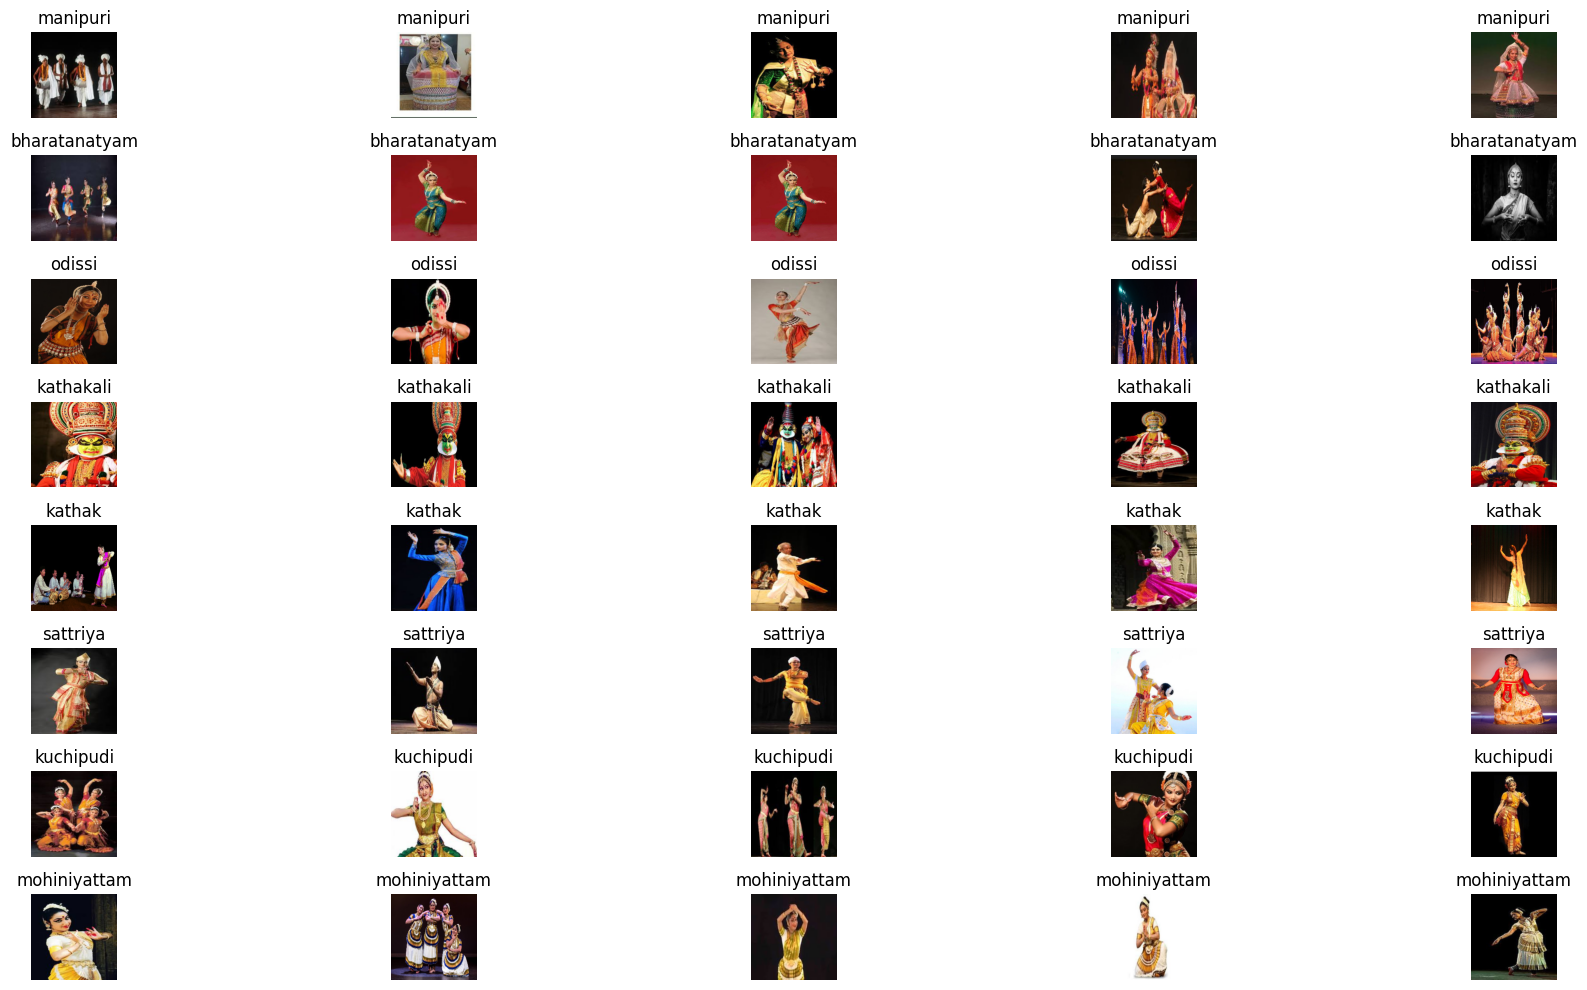

Class mapping: {'bharatanatyam': np.int64(0), 'kathak': np.int64(1), 'kathakali': np.int64(2), 'kuchipudi': np.int64(3), 'manipuri': np.int64(4), 'mohiniyattam': np.int64(5), 'odissi': np.int64(6), 'sattriya': np.int64(7)}


In [ ]:
# Let's create a function to load and preprocess images
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    try:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        img = cv2.resize(img, target_size)
        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

# Visualize some images from each class
plt.figure(figsize=(20, 10))
classes = train_df['target'].unique()

for i, dance_form in enumerate(classes):
    if i >= 8:  # Limit to 8 classes for visualization
        break

    sample_imgs = train_df[train_df['target'] == dance_form]['Image'].values[:5]
    for j, img_name in enumerate(sample_imgs):
        if j >= 5:  # Limit to 5 images per class
            break

        img_path = os.path.join(image_dir, img_name)
        img = load_and_preprocess_image(img_path)

        if img is not None:
            plt.subplot(8, 5, i*5 + j + 1)
            plt.imshow(img)
            plt.title(f"{dance_form}")
            plt.axis('off')

plt.tight_layout()
plt.show()

# Create label encoder
label_encoder = LabelEncoder()
train_df['encoded_target'] = label_encoder.fit_transform(train_df['target'])

# Print classes and their encoded values
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class mapping:", class_mapping)

# Create X_train and y_train
X_train_filenames = train_df['Image'].values
y_train = train_df['encoded_target'].values

# Create X_test (if available)
if 'target' in test_df.columns:
    test_df['encoded_target'] = label_encoder.transform(test_df['target'])
    X_test_filenames = test_df['Image'].values
    y_test = test_df['encoded_target'].values
else:
    # If test.csv doesn't have targets, split the training data
    X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(
        X_train_filenames, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

In [ ]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = len(label_encoder.classes_)

# Create train and validation splits
train_idx, val_idx = train_test_split(
    np.arange(len(X_train_filenames)),
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

train_files = X_train_filenames[train_idx]
train_labels = y_train[train_idx]
val_files = X_train_filenames[val_idx]
val_labels = y_train[val_idx]

# Map numeric labels back to class names for the generators
train_label_names = [label_encoder.classes_[label] for label in train_labels]
val_label_names = [label_encoder.classes_[label] for label in val_labels]

# Create DataFrames for generators
train_df_gen = pd.DataFrame({
    'filename': train_files,
    'class': train_label_names  # Use class names instead of numeric indices
})

val_df_gen = pd.DataFrame({
    'filename': val_files,
    'class': val_label_names  # Use class names instead of numeric indices
})

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create train and validation generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df_gen,
    directory=image_dir,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df_gen,
    directory=image_dir,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Check the class indices to make sure they match our label encoder
print("Generator class indices:", train_generator.class_indices)
print("Label encoder classes:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Found 232 validated image filenames belonging to 8 classes.
Found 59 validated image filenames belonging to 8 classes.
Generator class indices: {'bharatanatyam': 0, 'kathak': 1, 'kathakali': 2, 'kuchipudi': 3, 'manipuri': 4, 'mohiniyattam': 5, 'odissi': 6, 'sattriya': 7}
Label encoder classes: {'bharatanatyam': 0, 'kathak': 1, 'kathakali': 2, 'kuchipudi': 3, 'manipuri': 4, 'mohiniyattam': 5, 'odissi': 6, 'sattriya': 7}


In [ ]:
# Build the MobileNetV2 model
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

print("Model summary:")
model.summary()

Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.1477 - loss: 2.6305 - val_accuracy: 0.3390 - val_loss: 1.7345 - learning_rate: 0.0010
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.3268 - loss: 1.9574 - val_accuracy: 0.5254 - val_loss: 1.5214 - learning_rate: 0.0010
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3743 - loss: 1.6201 - val_accuracy: 0.5085 - val_loss: 1.4111 - learning_rate: 0.0010
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4626 - loss: 1.4367 - val_accuracy: 0.6271 - val_loss: 1.2497 - learning_rate: 0.0010
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5051 - loss: 1.3674 - val_accuracy: 0.6610 - val_loss: 1.1634 - learning_rate: 0.0010
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5810 - loss: 1.1761 - val_accuracy: 0.6780 - val_loss: 1.0971 - learning_rate: 0.0010
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5817 - loss: 1.1634 - val_accuracy: 0.6610 - val_l

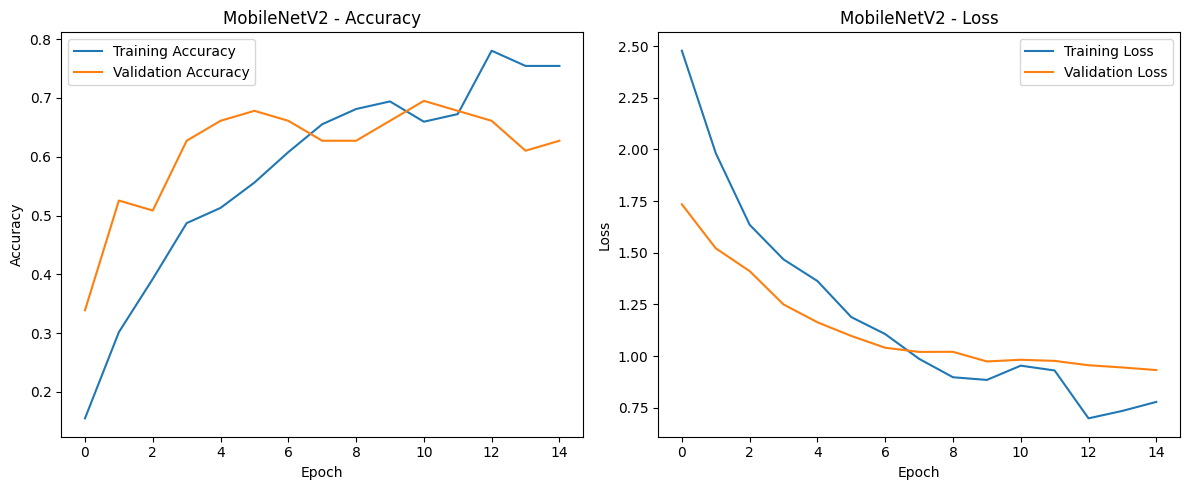

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
MobileNetV2 Accuracy: 62.71%

MobileNetV2 Classification Report:
               precision    recall  f1-score   support

bharatanatyam       0.67      0.50      0.57         8
       kathak       1.00      0.29      0.44         7
    kathakali       0.80      1.00      0.89         8
    kuchipudi       0.12      0.14      0.13         7
     manipuri       1.00      0.67      0.80         6
 mohiniyattam       0.89      1.00      0.94         8
       odissi       0.71      0.62      0.67         8
     sattriya       0.38      0.71      0.50         7

     accuracy                           0.63        59
    macro avg       0.70      0.62      0.62        59
 weighted avg       0.70      0.63      0.63        59



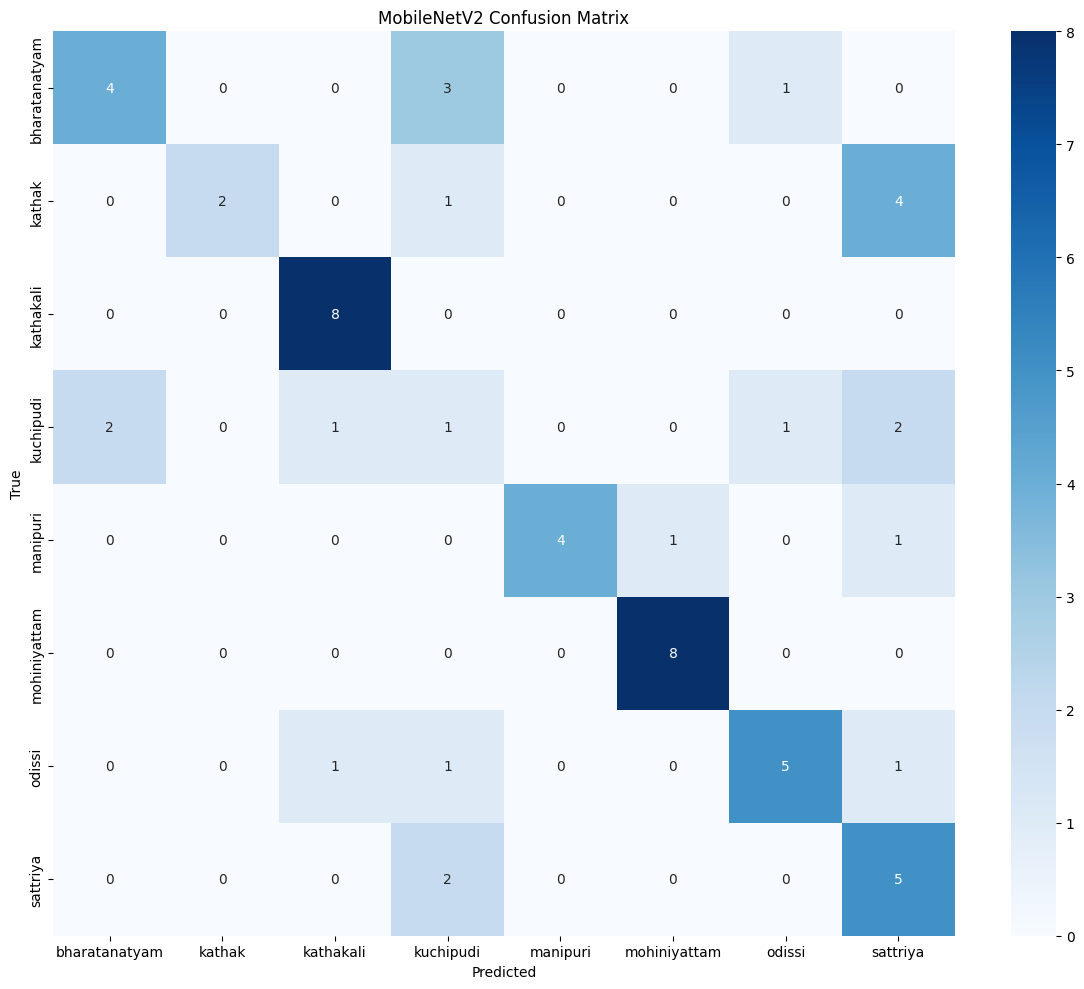

In [ ]:
# Train the MobileNetV2 model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, reduce_lr]
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the MobileNetV2 model
mobilenet_preds = model.predict(validation_generator)
mobilenet_pred_classes = np.argmax(mobilenet_preds, axis=1)
mobilenet_true_classes = validation_generator.classes

# Calculate accuracy
mobilenet_accuracy = accuracy_score(mobilenet_true_classes, mobilenet_pred_classes)
print(f"MobileNetV2 Accuracy: {mobilenet_accuracy * 100:.2f}%")

# Generate classification report
print("\nMobileNetV2 Classification Report:")
print(classification_report(mobilenet_true_classes, mobilenet_pred_classes,
                           target_names=label_encoder.classes_))

# Plot confusion matrix
plt.figure(figsize=(12, 10))
conf_matrix = confusion_matrix(mobilenet_true_classes, mobilenet_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('MobileNetV2 Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
# Create a feature extractor from MobileNetV2
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Function to extract features from images
def extract_features(image_paths, directory):
    features = []
    for img_path in tqdm(image_paths):
        full_path = os.path.join(directory, img_path)
        img = load_and_preprocess_image(full_path)
        if img is not None:
            img = img / 255.0  # Normalize
            img = np.expand_dims(img, axis=0)
            feature = feature_extractor.predict(img, verbose=0)
            feature = feature.reshape(1, -1)
            features.append(feature[0])
        else:
            # Use zeros as features for corrupted images
            features.append(np.zeros((1, 7*7*1280))[0])

    return np.array(features)

# Extract features for training and testing sets
print("Extracting features for training set...")
X_train_features = extract_features(train_files, image_dir)
print("Extracting features for validation set...")
X_val_features = extract_features(val_files, image_dir)

# Save the features to avoid recomputing (optional)
np.save('X_train_features.npy', X_train_features)
np.save('X_val_features.npy', X_val_features)
np.save('y_train.npy', train_labels)
np.save('y_val.npy', val_labels)

Extracting features for training set...


100%|██████████| 232/232 [00:43<00:00,  5.37it/s]


Extracting features for validation set...


100%|██████████| 59/59 [00:11<00:00,  5.26it/s]


Training Random Forest classifier...
Random Forest Accuracy: 66.10%

Random Forest Classification Report:
               precision    recall  f1-score   support

bharatanatyam       0.57      0.50      0.53         8
       kathak       1.00      0.57      0.73         7
    kathakali       1.00      1.00      1.00         8
    kuchipudi       0.40      0.57      0.47         7
     manipuri       1.00      0.67      0.80         6
 mohiniyattam       0.75      0.75      0.75         8
       odissi       0.83      0.62      0.71         8
     sattriya       0.33      0.57      0.42         7

     accuracy                           0.66        59
    macro avg       0.74      0.66      0.68        59
 weighted avg       0.74      0.66      0.68        59



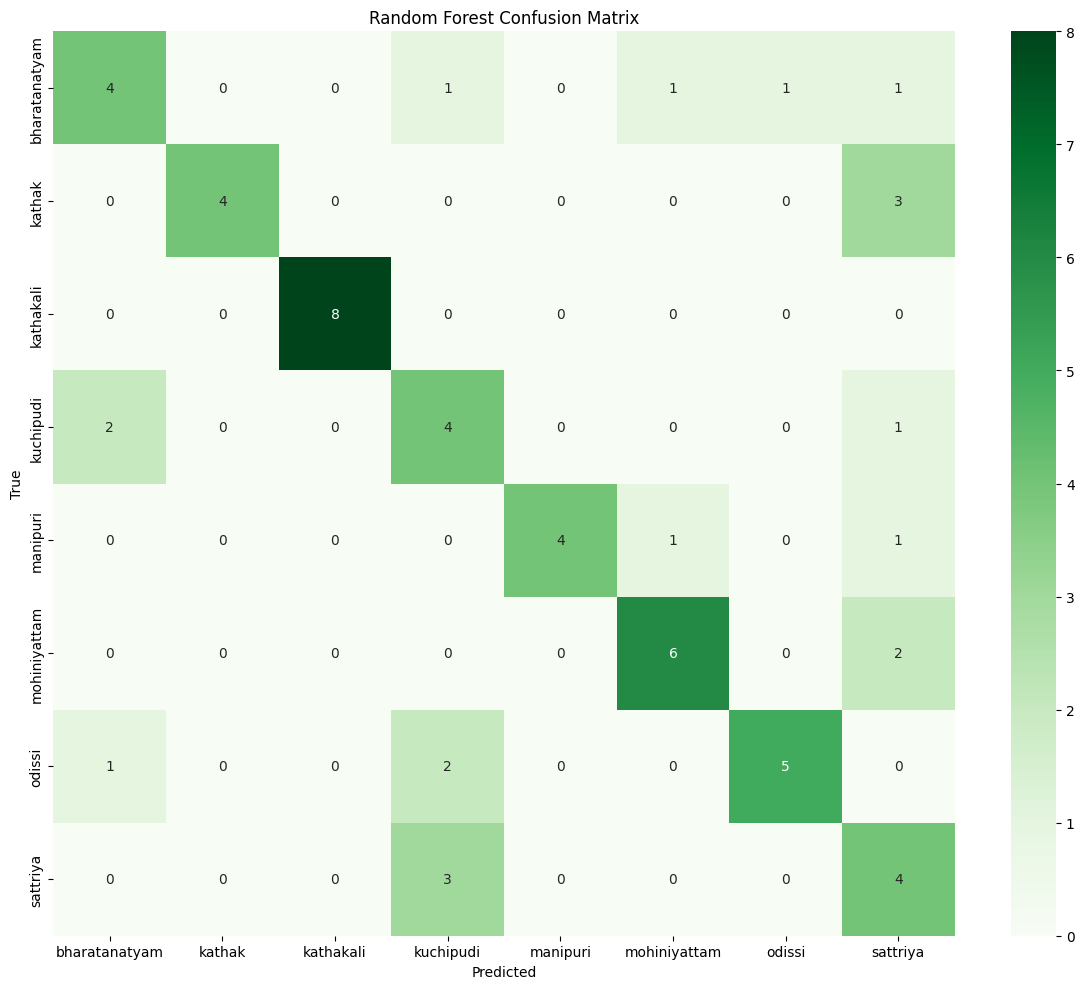

In [ ]:
# Train Random Forest classifier
print("Training Random Forest classifier...")
rf_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

rf_clf.fit(X_train_features, train_labels)

# Evaluate Random Forest
rf_preds = rf_clf.predict(X_val_features)
rf_accuracy = accuracy_score(val_labels, rf_preds)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

# Generate classification report
print("\nRandom Forest Classification Report:")
print(classification_report(val_labels, rf_preds,
                           target_names=label_encoder.classes_))

# Plot confusion matrix
plt.figure(figsize=(12, 10))
conf_matrix = confusion_matrix(val_labels, rf_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()


Training SVM classifier...
SVM Accuracy: 45.76%

SVM Classification Report:
               precision    recall  f1-score   support

bharatanatyam       1.00      0.38      0.55         8
       kathak       0.00      0.00      0.00         7
    kathakali       0.29      1.00      0.44         8
    kuchipudi       0.38      0.43      0.40         7
     manipuri       1.00      0.33      0.50         6
 mohiniyattam       0.88      0.88      0.88         8
       odissi       0.50      0.50      0.50         8
     sattriya       0.00      0.00      0.00         7

     accuracy                           0.46        59
    macro avg       0.50      0.44      0.41        59
 weighted avg       0.51      0.46      0.42        59



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


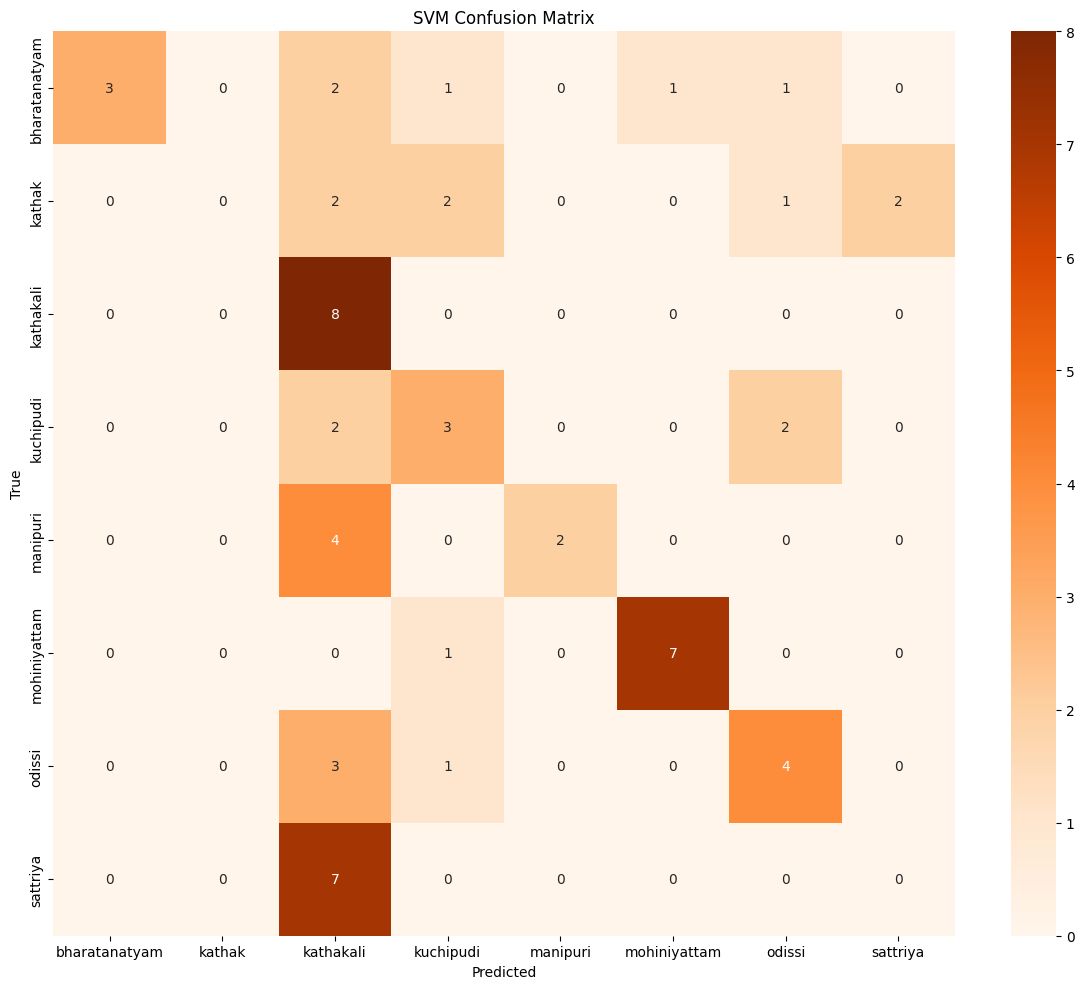

In [ ]:
# Train SVM classifier
print("Training SVM classifier...")
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42))
])

svm_clf.fit(X_train_features, train_labels)

# Evaluate SVM
svm_preds = svm_clf.predict(X_val_features)
svm_accuracy = accuracy_score(val_labels, svm_preds)
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")

# Generate classification report
print("\nSVM Classification Report:")
print(classification_report(val_labels, svm_preds,
                           target_names=label_encoder.classes_))

# Plot confusion matrix
plt.figure(figsize=(12, 10))
conf_matrix = confusion_matrix(val_labels, svm_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.tight_layout()
plt.show()

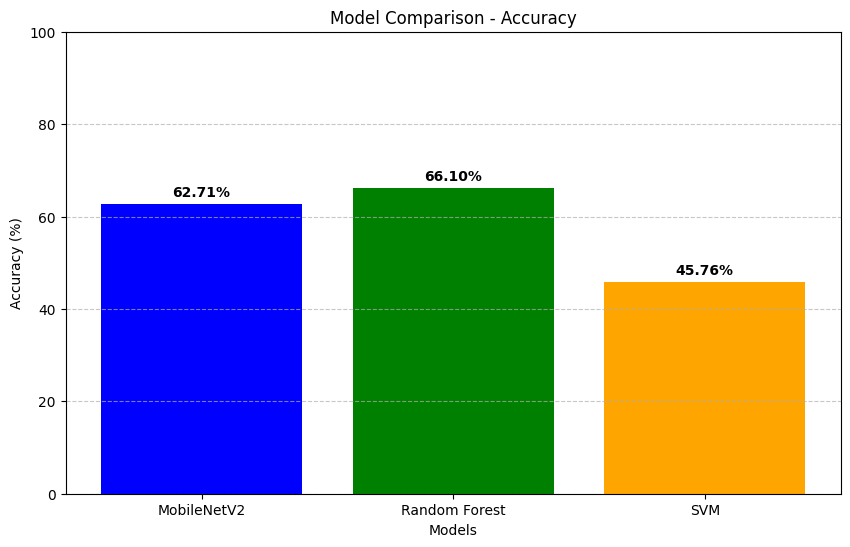


Model Comparison Table:
           Model  Accuracy (%)
0    MobileNetV2     62.711864
1  Random Forest     66.101695
2            SVM     45.762712


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1400x800 with 0 Axes>

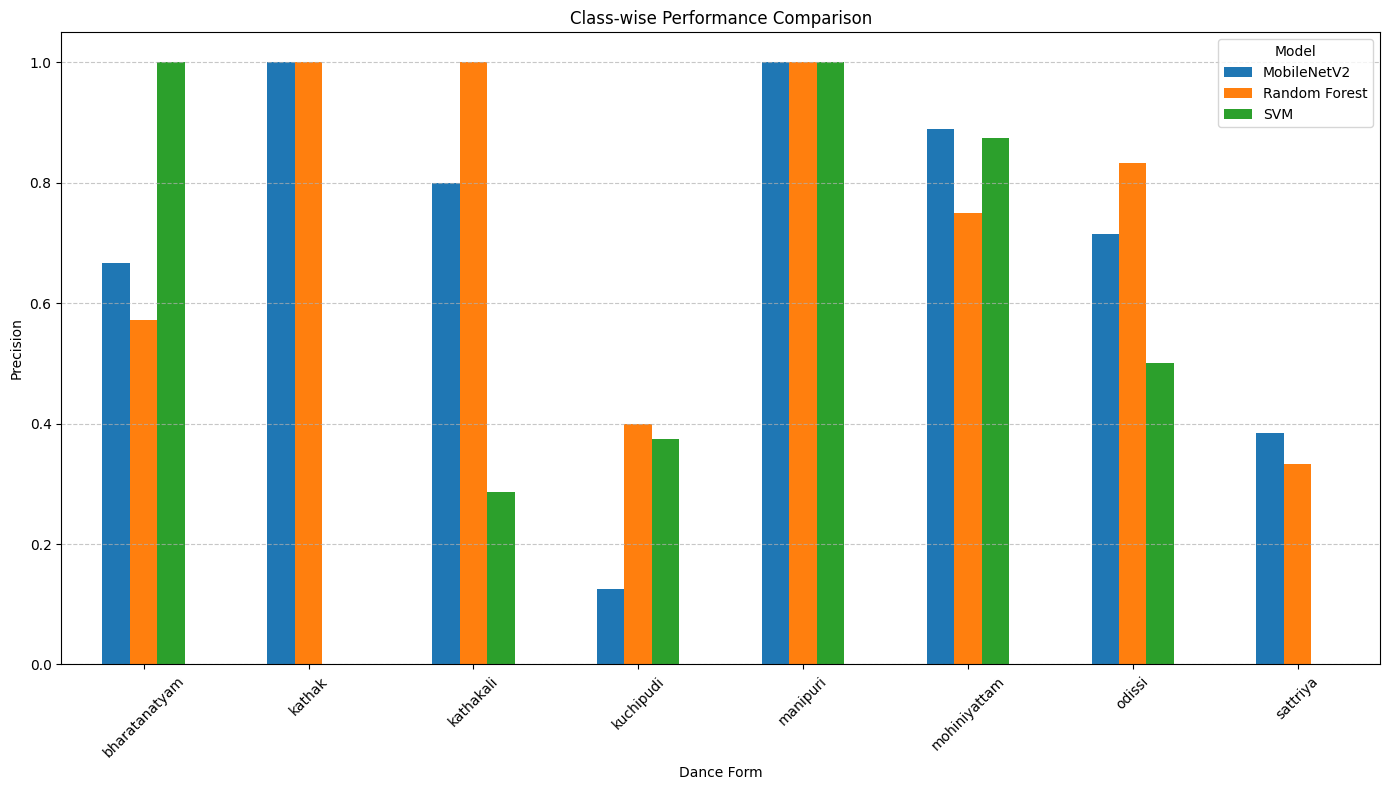

In [ ]:
# Compare model performances
models = ['MobileNetV2', 'Random Forest', 'SVM']
accuracies = [mobilenet_accuracy, rf_accuracy, svm_accuracy]

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(models, [acc * 100 for acc in accuracies], color=['blue', 'green', 'orange'])

# Add accuracy values on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc * 100:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.title('Model Comparison - Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Create a comparison table
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy (%)': [acc * 100 for acc in accuracies]
})
print("\nModel Comparison Table:")
print(comparison_df)

# Calculate class-wise accuracy for each model
class_accuracies = {}

# MobileNetV2
mobilenet_report = classification_report(mobilenet_true_classes, mobilenet_pred_classes,
                                        target_names=label_encoder.classes_, output_dict=True)
class_accuracies['MobileNetV2'] = {cls: mobilenet_report[cls]['precision'] for cls in label_encoder.classes_}

# Random Forest
rf_report = classification_report(val_labels, rf_preds,
                                 target_names=label_encoder.classes_, output_dict=True)
class_accuracies['Random Forest'] = {cls: rf_report[cls]['precision'] for cls in label_encoder.classes_}

# SVM
svm_report = classification_report(val_labels, svm_preds,
                                  target_names=label_encoder.classes_, output_dict=True)
class_accuracies['SVM'] = {cls: svm_report[cls]['precision'] for cls in label_encoder.classes_}

# Create a DataFrame for class-wise performance
class_perf_df = pd.DataFrame(class_accuracies)

# Plot class-wise performance
plt.figure(figsize=(14, 8))
class_perf_df.plot(kind='bar', figsize=(14, 8))
plt.title('Class-wise Performance Comparison')
plt.xlabel('Dance Form')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [ ]:
# Debug code to check paths and files
import os

base_dir = "/content/dance_dataset"
train_csv_path = os.path.join(base_dir, "train.csv")

# Check if the CSV exists
print(f"Train CSV exists: {os.path.exists(train_csv_path)}")

# Read the CSV
train_df = pd.read_csv(train_csv_path)
print(f"First few rows of train_df:\n{train_df.head()}")

# Check the image directory structure
print("\nDirectory structure:")
# List contents of base_dir
print(f"Contents of {base_dir}:")
print(os.listdir(base_dir))

# Try to find where the images actually are
possible_image_dirs = [
    base_dir,
    os.path.join(base_dir, "images"),
    os.path.join(base_dir, "train")
]

# Check a sample image path from each potential directory
sample_img_name = train_df['Image'].iloc[0]
print(f"\nSample image name from CSV: {sample_img_name}")

for img_dir in possible_image_dirs:
    if os.path.exists(img_dir):
        sample_path = os.path.join(img_dir, sample_img_name)
        print(f"Checking {sample_path}: {os.path.exists(sample_path)}")

        # If this directory doesn't work, look for subdirectories
        if not os.path.exists(sample_path):
            subdirs = [d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))]
            print(f"Subdirectories in {img_dir}: {subdirs}")

            for subdir in subdirs:
                subdir_path = os.path.join(img_dir, subdir)
                sub_sample_path = os.path.join(subdir_path, sample_img_name)
                print(f"Checking {sub_sample_path}: {os.path.exists(sub_sample_path)}")

Train CSV exists: True
First few rows of train_df:
     Image         target
0   96.jpg       manipuri
1  163.jpg  bharatanatyam
2  450.jpg         odissi
3  219.jpg      kathakali
4  455.jpg         odissi

Directory structure:
Contents of /content/dance_dataset:
['test', 'test.csv', 'train.csv', 'train']

Sample image name from CSV: 96.jpg
Checking /content/dance_dataset/96.jpg: False
Subdirectories in /content/dance_dataset: ['test', 'train']
Checking /content/dance_dataset/test/96.jpg: False
Checking /content/dance_dataset/train/96.jpg: True
Checking /content/dance_dataset/train/96.jpg: True


In [ ]:
# Once you've found the correct image directory, update the image_dir variable
# For example, if images are in "/content/dance_dataset/images":
image_dir = "/content/dance_dataset/images"  # Update this based on debug results

# Check if some sample images exist in this directory
sample_imgs = train_df['Image'].head(3).values
for img in sample_imgs:
    img_path = os.path.join(image_dir, img)
    print(f"Image {img} exists: {os.path.exists(img_path)}")

# Create train/validation splits (80/20)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['target']
)

# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators with verbose output to debug issues
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='Image',
    y_col='target',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    validate_filenames=True  # Add this to verify files exist
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='Image',
    y_col='target',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    validate_filenames=True  # Add this to verify files exist
)

print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in validation_generator: {len(validation_generator)}")

Image 96.jpg exists: False
Image 163.jpg exists: False
Image 450.jpg exists: False
Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.
Number of batches in train_generator: 0
Number of batches in validation_generator: 0


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 291 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 73 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/dance_dataset/train',
    x_col='Image',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 291 validated image filenames belonging to 8 classes.


In [ ]:
train_df.head()

,Image,target,encoded_target
301,99.jpg,manipuri,4
306,490.jpg,odissi,6
261,266.jpg,mohiniyattam,5
90,516.jpg,odissi,6
95,299.jpg,mohiniyattam,5


In [ ]:
import os

# Check if all files exist
missing_files = [f for f in train_df['Image'] if not os.path.exists(f'/content/dance_dataset/train/{f}')]

print(f"Missing files: {missing_files}")

Missing files: []


In [ ]:
print(f"Length of train_generator: {len(train_generator)}")

Length of train_generator: 10


In [ ]:
train_df['Image'] = train_df['Image'].str.strip()

In [ ]:
!pip install joblib

In [ ]:
import joblib

In [ ]:
# Assuming 'rf_clf' is your trained Random Forest model
joblib.dump(rf_clf,'random_forest_model.pkl')

['random_forest_model.pkl']

In [ ]:
# Assuming 'svm_model' is your trained SVM model
joblib.dump(svm_clf, 'svm_model.pkl')

['svm_model.pkl']

In [ ]:
# Load the Random Forest model
rf_model = joblib.load('random_forest_model.pkl')

# Load the SVM model
svm_model = joblib.load('svm_model.pkl')

In [ ]:
# Assuming 'mobilenet_model' is your trained MobileNetV2 model
# Assuming 'model' is your trained MobileNetV2 model (renamed from 'mobilenet_model')
model.save('mobilenetv2_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Load the MobileNetV2 model
mobilenet_model = load_model('mobilenetv2_model.keras')

In [ ]:
train_df['image_path'] = train_df['Image'].apply(lambda x: image_dir / x)

**STREAMLIT DASHBOARD SETUP**

In [ ]:
!pip install -q streamlit pyngrok

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your trained model file here (mobilenetv2_model.h5)

Saving mobilenetv2_model.keras to mobilenetv2_model (1).keras


In [105]:
%%writefile streamlit_app.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# Load the trained model
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model("mobilenetv2_model.keras")  # make sure this matches your uploaded model file
    return model

model = load_model()

# Class labels (update these based on your actual classes)
class_names = ['Bharatanatyam', 'Kathak', 'Kuchipudi', 'Odissi', 'Manipuri', 'Mohiniyattam']  # example labels

st.title("💃 Dance Form Classifier")
st.write("Upload an image and get the predicted dance form!")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    img = Image.open(uploaded_file).convert('RGB')
    st.image(img, caption="Uploaded Image", use_column_width=True)

    # Preprocess the image
    img = img.resize((224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)

    # Predict
    prediction = model.predict(x)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    st.success(f"🎯 Predicted Dance Form: **{predicted_class}**")
    st.write(f"🧠 Confidence: {confidence:.2f}%")

Overwriting streamlit_app.py


In [ ]:
!ngrok authtoken <2vS3fTsAimth2wXJTuaGCSe37vZ_6diWYuuugEtdG7JPqq4na>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `ngrok authtoken <2vS3fTsAimth2wXJTuaGCSe37vZ_6diWYuuugEtdG7JPqq4na>'


In [ ]:
!pip install --upgrade pyngrok

In [102]:
!ngrok config add-authtoken 2vS3fTsAimth2wXJTuaGCSe37vZ_6diWYuuugEtdG7JPqq4na

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [108]:
from pyngrok import ngrok

# Set your auth token here
NGROK_AUTH_TOKEN = "2vS3fTsAimth2wXJTuaGCSe37vZ_6diWYuuugEtdG7JPqq4na"  # Replace with your actual token
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Kill previous tunnels (if any)
ngrok.kill()

# Run the app
!streamlit run streamlit_app.py &>/content/logs.txt &

# Get the public URL
# Note: 'addr' is preferred over 'port' in newer versions of pyngrok
public_url = ngrok.connect(addr="8501")
print("Streamlit app is live at:", public_url)

Streamlit app is live at: NgrokTunnel: "https://c51d-34-138-107-109.ngrok-free.app" -> "http://localhost:8501"
